In [61]:
# Step 1: Scrape Conversation from URL

import requests
from bs4 import BeautifulSoup
import re

url = "https://transcripts.recursiveprojects.cloud/archive/16255/164551"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')


In [63]:
# Step 2: Extract Conversations from the HTML

message_containers = soup.find_all('div', class_='flex flex-col sm:flex-row items-center dark:bg-zinc-800 mx-2 sm:mx-4 my-1 py-1 sm:pr-1 rounded-md')
 # Loop through each message container
conversations = []
timestamps = []

for container in message_containers:
    # Extract the timestamp and message text
    timestamp = container.find('span', class_='timestamp').find('span').text.strip()
    message = container.find('div', class_='grow mr-2').text.strip()
    conversations.append(message)
    timestamps.append(timestamp)

print(len(conversations))

112


In [66]:
# Step 3: Identify Driver's Messages Using LLaMA 3 LLM 

import pandas as pd
import ollama

# Load the CSV file
input_csv = 'f1_messages.csv'
df = pd.read_csv(input_csv)

# Combine all messages to form a single context
conversation = "\n".join(df['Message'])

# Create a prompt for the model with instructions and the conversation
prompt = f"""
Below is an F1 driver-engineer conversation. Identify the messages said by the driver. Drivers typically discuss their own performance, how the car is handling, issues they're facing, or provide feedback about track conditions. They are also more emotional on the radio
Engineers generally give instructions, provide status updates, ask about the car's condition, or discuss strategy. They are usually calmer on the radio
Please output the driver's messages only without any additional text.

Conversation:
{conversations}
"""

# Use the LLaMA 3 model to classify the conversation
response = ollama.chat(
    model="llama3",
    messages=[{"role": "user", "content": prompt}]
)

# Extract the response content
response_text = response['message']['content'].strip()

# Process the response to create a list of classifications
driver_messages = response_text.split("\n")
driver_timestamps = []

for message in driver_messages:
    for i, convo in enumerate(conversations):
        if message in convo:
            driver_timestamps.append(timestamps[i])
            break


In [32]:
# Step 4: Sentiment Analysis on Driver's Messages

# Create a prompt for the model with instructions and the conversation
prompt = f"""
Below is an array of driver's messages from an F1 driver-engineer conversation. Perform sentiment analysis on these messages and provide the sentiment score as an integer between -10 and +10 for each message.
Output only the score in the format 'Message : score', without any explanations or additional text.

Messages:
{driver_messages}
"""

# Use the LLaMA 3 model to classify the conversation
response = ollama.chat(
    model="llama3",
    messages=[{"role": "user", "content": prompt}]
)

# Extract the response content
response_text = response['message']['content'].strip()

# Process the response to create a list of classifications
classification_lines = [line.split(": ") for line in response_text.split("\n") if ": " in line]
message_sentiment = [(msg.strip(), int(score.strip())) for msg, score in classification_lines]

# Print the processed sentiment analysis for verification
for msg, sentiment in message_sentiment:
    print(f"Message: {msg} | Sentiment: {sentiment}")

# Use message_sentiment to plot the time vs sentiment graph


Message: I will use DRS if I do that. | Sentiment: 0
Message: On what? Tyre phase. Tyre phase. I've done it already. | Sentiment: -5
Message: I'm trying, it's very tricky. I know. Keep it up. | Sentiment: 6
Message: Plan front wing update. OK. | Sentiment: 1
Message: What was that? Why do we pit if we undercut? | Sentiment: -2
Message: Well, this I need to know. It's very different from Italian management. | Sentiment: 4
Message: Yeah, they are crazy fast there. | Sentiment: 5
Message: Peace. I know it's not ideal for you, but that's what it is. | Sentiment: -3
Message: If you can update me on the guys who are fighting, so the McLaren, Carlos, everybody around please. | Sentiment: 2
Message: So, Charles, Sainz thinking plan B and we are considering it. Plan B, what do you think? Piastri's in? Yeah. Hope he's out. | Sentiment: -1
Message: Just on water. | Sentiment: 0
Message: Leave me alone with this. If I don't do things you ask, don't ask that time. | Sentiment: -8
Message: But how d

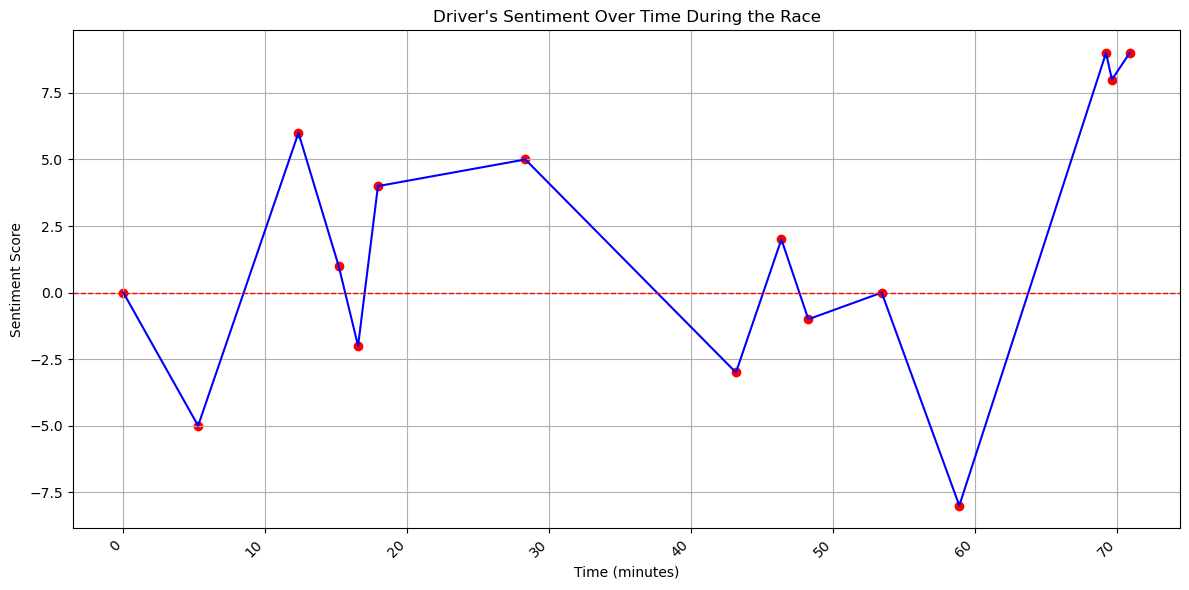

In [67]:
# Step 5: Plot the Time vs. Sentiment Graph for the Race

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from scipy.interpolate import make_interp_spline

# Extract the sentiments from message_sentiment
sentiments = [sentiment for _, sentiment in message_sentiment]
datetime_objects = [datetime.strptime(ts, '%H:%M:%S') for ts in driver_timestamps]


# Convert timestamps to datetime objects
datetime_objects = [datetime.strptime(ts, '%H:%M:%S') for ts in driver_timestamps]

# Convert datetime objects to numeric values (elapsed time in minutes)
elapsed_time = [(dt - datetime_objects[0]).total_seconds() / 60 for dt in datetime_objects]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(elapsed_time, sentiments, color='b')
plt.scatter(elapsed_time, sentiments, color='r')  # Add original data points
# Add horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Time (minutes)")
plt.ylabel("Sentiment Score")
plt.title("Driver's Sentiment Over Time During the Race")
plt.grid(True)

# Rotate and format x-axis labels
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()